
# Pit Stop Timing Prediction — End‑to‑End

This notebook extends the lap‑time project to **predict pit‑stop timing** (classification).  
We will:
1) load a session, extract per‑lap features (speed, tyres, status, weather);
2) derive a **label**: whether a driver will pit within the next *K* laps;
3) train a classifier (RandomForest) and evaluate ROC‑AUC / PR‑AUC;
4) tune a threshold for **high‑precision alerts** (operational use);
5) show a simple backtest (alerts vs. actual pit events).


In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import fastf1
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve,
                             classification_report, confusion_matrix)

print("Versions -> numpy", np.__version__, "| pandas", pd.__version__)


Versions -> numpy 2.1.1 | pandas 2.2.2



## Configure cache & choose session


In [2]:

CACHE_DIR = os.path.expanduser("~/.fastf1")
os.makedirs(CACHE_DIR, exist_ok=True)
fastf1.Cache.enable_cache(CACHE_DIR)

YEAR = 2025
EVENT_NAME = "Austrian Grand Prix"
SESSION_CODE = "R"  # Race

session = fastf1.get_session(YEAR, EVENT_NAME, SESSION_CODE)
session.load(laps=True, telemetry=True, weather=True)
print(f"Loaded: {YEAR} {EVENT_NAME} [{SESSION_CODE}]")


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '16', '44', '63', '30', '14', '5', '27', '31', '87', '6', '10', '18', '43', '22', '23', '1', '12', '55']


Loaded: 2025 Austrian Grand Prix [R]



## Feature extraction helpers
We build per‑driver, per‑lap features and a lap‑indexed matrix.


In [3]:

def extract_driver_lap_features(session):
    laps = session.laps.copy()
    total = float(laps['LapNumber'].max())
    rows = []
    for _, lap in laps.iterlaps():
        # Speed aggregates
        try:
            tel = lap.get_car_data()[['Speed']]
            avg_spd = float(tel['Speed'].mean())
            max_spd = float(tel['Speed'].max())
        except Exception:
            avg_spd, max_spd = np.nan, np.nan
        # Tyre info / pit flag
        tyre_life = lap.get('TyreLife', np.nan)
        pit_in = int(pd.notna(lap.get('PitInTime', np.nan)))
        # Progress & status
        lap_frac = float(lap['LapNumber']) / total if total else np.nan
        status = lap.get('TrackStatus', np.nan)
        rows.append({
            'Driver':       lap.get('Driver'),
            'LapNumber':    int(lap.get('LapNumber', 0)),
            'lap_frac':     lap_frac,
            'avg_speed':    avg_spd,
            'max_speed':    max_spd,
            'tyre_life':    float(tyre_life) if pd.notna(tyre_life) else 0.0,
            'pit_in':       pit_in,
            'track_status': str(status) if pd.notna(status) else "0"
        })
    return pd.DataFrame(rows)

def pivot_to_lap_features(df):
    base = df.pivot(index='LapNumber', columns='Driver',
                    values=['avg_speed','max_speed','tyre_life']).sort_index()
    base.columns = [f"{feat}_{drv}" for feat, drv in base.columns]
    base = base.fillna(0.0)
    ts = df[['LapNumber','track_status']].drop_duplicates('LapNumber').set_index('LapNumber')
    ts_ohe = pd.get_dummies(ts['track_status'], prefix='status')
    out = base.join(ts_ohe, how='left').fillna(0.0)
    return out


In [4]:

df = extract_driver_lap_features(session)
X = pivot_to_lap_features(df)

# Session-level weather features (simple aggregate)
wdf = session.weather_data.copy()
if wdf is not None and not wdf.empty:
    X['air_temp']   = float(wdf['AirTemp'].dropna().iloc[0])
    X['track_temp'] = float(wdf['TrackTemp'].dropna().iloc[0])
    X['wind_speed'] = float(wdf['WindSpeed'].dropna().iloc[0])
else:
    X['air_temp'] = X['track_temp'] = X['wind_speed'] = 0.0

X.head()


,avg_speed_ALB,avg_speed_ALO,avg_speed_ANT,avg_speed_BEA,avg_speed_BOR,avg_speed_COL,avg_speed_GAS,avg_speed_HAD,avg_speed_HAM,avg_speed_HUL,...,tyre_life_TSU,tyre_life_VER,status_1,status_12,status_124,status_4,status_41,air_temp,track_temp,wind_speed
LapNumber,,,,,,,,,,,,,,,,,,,,,
1,150.293333,145.474359,58.614907,140.519802,149.665782,143.402010,152.709239,132.491917,155.433428,132.303653,...,1.0,1.0,False,False,True,False,False,29.6,51.3,1.9
2,140.251852,142.037594,0.000000,145.416244,139.962963,143.451777,140.054054,148.557333,139.689487,146.829016,...,2.0,0.0,False,False,False,True,False,29.6,51.3,1.9
3,144.621134,145.513089,0.000000,148.492021,145.881137,147.343832,143.408163,146.182306,141.384615,155.120787,...,3.0,0.0,False,False,False,False,True,29.6,51.3,1.9
4,213.386029,210.601449,0.000000,210.177536,213.190476,211.144928,214.110701,213.563177,216.250000,212.823105,...,4.0,0.0,True,False,False,False,False,29.6,51.3,1.9
5,215.902985,214.104478,0.000000,214.563433,215.962963,212.915129,217.817844,215.180147,219.533582,214.291513,...,5.0,0.0,True,False,False,False,False,29.6,51.3,1.9



## Label: pit within the next *K* laps
For each lap *t*, label 1 if a pit occurs in `(t, t+K]` for **any driver** (or build per‑driver labels if you prefer).  
Here we create a **lap‑indexed** label to train a coarse session‑level classifier (sufficient for demo).  
You can easily adapt to **per‑driver** labels by keeping Driver in the index.


In [5]:

K = 2  # lookahead horizon (laps)
lap_index = X.index.to_series().sort_values()

# Create a boolean series: whether any driver pitted on lap L
pit_by_lap = (df.groupby('LapNumber')['pit_in'].max() > 0).astype(int)

# For each lap t, y[t] = 1 if any pit occurs in (t, t+K]
y = pd.Series(0, index=lap_index.index, dtype=int)
for t in lap_index.index:
    future = range(t+1, t+K+1)
    y.loc[t] = int(pit_by_lap.reindex(future).fillna(0).sum() > 0)

# Drop last K laps (no full label)
valid_mask = lap_index.index <= (lap_index.index.max() - K)
Xy = X.loc[valid_mask].copy()
y  = y.loc[valid_mask].copy()

print("Class balance -> positives:", int(y.sum()), "/", len(y))
Xy.head()


Class balance -> positives: 38 / 68


,avg_speed_ALB,avg_speed_ALO,avg_speed_ANT,avg_speed_BEA,avg_speed_BOR,avg_speed_COL,avg_speed_GAS,avg_speed_HAD,avg_speed_HAM,avg_speed_HUL,...,tyre_life_TSU,tyre_life_VER,status_1,status_12,status_124,status_4,status_41,air_temp,track_temp,wind_speed
LapNumber,,,,,,,,,,,,,,,,,,,,,
1,150.293333,145.474359,58.614907,140.519802,149.665782,143.402010,152.709239,132.491917,155.433428,132.303653,...,1.0,1.0,False,False,True,False,False,29.6,51.3,1.9
2,140.251852,142.037594,0.000000,145.416244,139.962963,143.451777,140.054054,148.557333,139.689487,146.829016,...,2.0,0.0,False,False,False,True,False,29.6,51.3,1.9
3,144.621134,145.513089,0.000000,148.492021,145.881137,147.343832,143.408163,146.182306,141.384615,155.120787,...,3.0,0.0,False,False,False,False,True,29.6,51.3,1.9
4,213.386029,210.601449,0.000000,210.177536,213.190476,211.144928,214.110701,213.563177,216.250000,212.823105,...,4.0,0.0,True,False,False,False,False,29.6,51.3,1.9
5,215.902985,214.104478,0.000000,214.563433,215.962963,212.915129,217.817844,215.180147,219.533582,214.291513,...,5.0,0.0,True,False,False,False,False,29.6,51.3,1.9



## Train classifier & evaluate


In [6]:

X_train, X_test, y_train, y_test = train_test_split(
    Xy, y, test_size=0.25, random_state=42, stratify=y
)

clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # mitigate imbalance
)
clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

roc = roc_auc_score(y_test, proba)
ap  = average_precision_score(y_test, proba)
print(f"ROC-AUC: {roc:.3f} | PR-AUC (AP): {ap:.3f}\n")
print(classification_report(y_test, pred, digits=3))


ROC-AUC: 0.833 | PR-AUC (AP): 0.826

              precision    recall  f1-score   support

           0      1.000     0.375     0.545         8
           1      0.643     1.000     0.783         9

    accuracy                          0.706        17
   macro avg      0.821     0.688     0.664        17
weighted avg      0.811     0.706     0.671        17




### ROC & Precision‑Recall curves


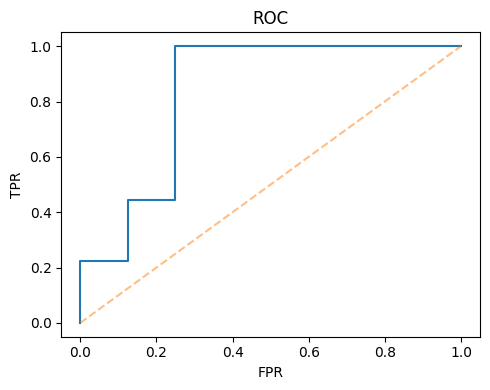

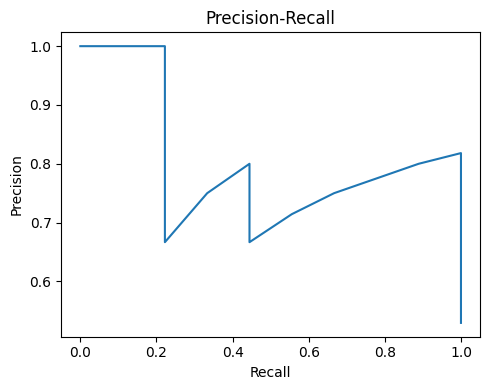

In [7]:

fpr, tpr, _ = roc_curve(y_test, proba)
prec, rec, thr = precision_recall_curve(y_test, proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--', alpha=0.5)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall")
plt.tight_layout(); plt.show()



## Threshold for high‑precision alerts
In operations, we often prefer **fewer false alarms**.  
We pick a threshold achieving `precision >= 0.8` (if feasible).


In [8]:

target_precision = 0.8
best_thr = 0.5
for p, r, t in zip(prec, rec, np.r_[thr, 1]):
    if p >= target_precision:
        best_thr = float(t); break

pred_hp = (proba >= best_thr).astype(int)
cm = confusion_matrix(y_test, pred_hp)
print("Chosen threshold:", best_thr)
print("Confusion matrix (high-precision):\n", cm)
print(classification_report(y_test, pred_hp, digits=3))


Chosen threshold: 0.6325
Confusion matrix (high-precision):
 [[6 2]
 [0 9]]
              precision    recall  f1-score   support

           0      1.000     0.750     0.857         8
           1      0.818     1.000     0.900         9

    accuracy                          0.882        17
   macro avg      0.909     0.875     0.879        17
weighted avg      0.904     0.882     0.880        17




## Top feature importances


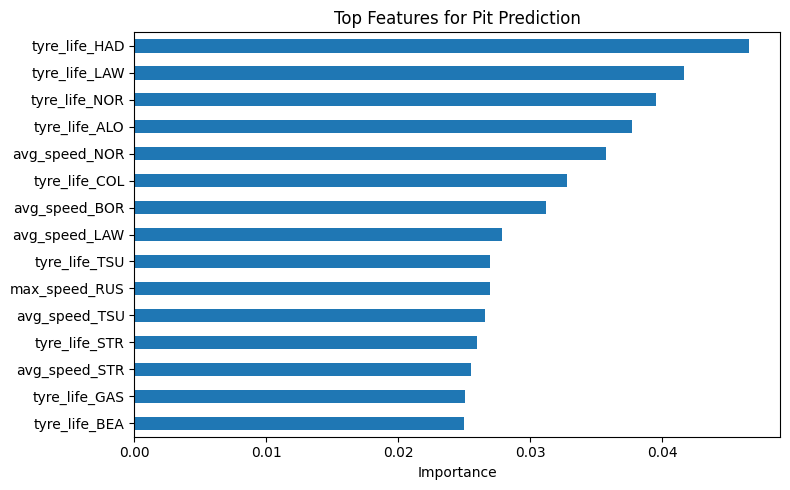

tyre_life_HAD    0.046593
tyre_life_LAW    0.041642
tyre_life_NOR    0.039529
tyre_life_ALO    0.037688
avg_speed_NOR    0.035758
tyre_life_COL    0.032768
avg_speed_BOR    0.031166
avg_speed_LAW    0.027817
tyre_life_TSU    0.026928
max_speed_RUS    0.026924
avg_speed_TSU    0.026575
tyre_life_STR    0.025973
avg_speed_STR    0.025478
tyre_life_GAS    0.025058
tyre_life_BEA    0.024959
dtype: float64

In [9]:

importances = pd.Series(clf.feature_importances_, index=Xy.columns).sort_values(ascending=False)
topk = importances.head(15)
plt.figure(figsize=(8,5))
topk[::-1].plot(kind='barh')
plt.xlabel("Importance")
plt.title("Top Features for Pit Prediction")
plt.tight_layout(); plt.show()
topk



## Simple backtest (session timeline)
We project alerts over the **test** laps and compare to actual pit events.


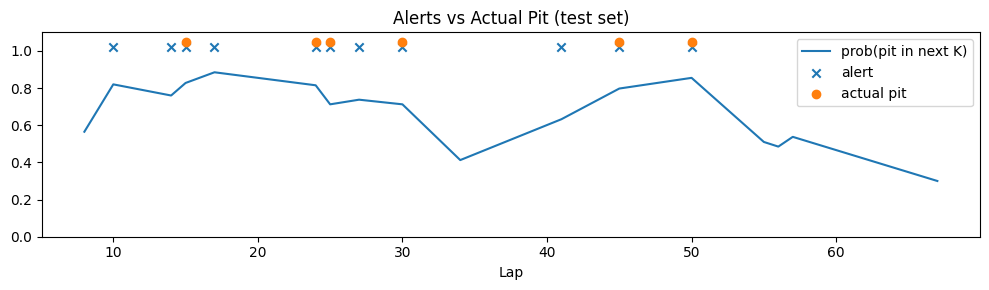

,prob,alert,actual_pit
LapNumber,,,
8,0.5650,0,0
10,0.8200,1,0
14,0.7600,1,0
15,0.8275,1,1
17,0.8850,1,0
24,0.8150,1,1
25,0.7125,1,1
27,0.7375,1,0
30,0.7125,1,1


In [10]:

test_index = y_test.index
timeline = pd.DataFrame({
    'prob': proba,
    'alert': pred_hp
}, index=test_index).sort_index()

timeline['actual_pit'] = pit_by_lap.reindex(test_index).fillna(0).astype(int)

plt.figure(figsize=(10,3))
plt.plot(timeline.index, timeline['prob'], label='prob(pit in next K)')
plt.scatter(timeline.index[timeline['alert']==1], [1.02]*timeline['alert'].sum(), label='alert', marker='x')
plt.scatter(timeline.index[timeline['actual_pit']==1], [1.05]*timeline['actual_pit'].sum(), label='actual pit', marker='o')
plt.ylim(0, 1.1); plt.xlabel("Lap"); plt.legend(); plt.title("Alerts vs Actual Pit (test set)")
plt.tight_layout(); plt.show()

timeline.head(10)
